In [1]:
import numpy as np
import scipy.stats
import seaborn as sbn
import torch
from sklearn.datasets import load_boston

from prior_elicitation.models.folded_logistic_glm import FoldedLogisticGLM
from prior_elicitation.models.linear_glm import LinearGLM

In [2]:
#parameters
MODEL: str = "folded-logistic"
COLUMN: str = "intercept"
PERCENTILE: int = 25
PRIOR_INFO: dict = {
    'AGE': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'B': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'CHAS': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'CRIM': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'DIS': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'INDUS': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'LSTAT': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'NOX': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'PTRATIO': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'RAD': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'RM': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'TAX': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'ZN': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'intercept': {'dist': 'norm', 'loc': 0, 'scale': 1},
    'scale': {'c': 0, 'dist': 'foldnorm', 'loc': 10, 'scale': 1}}
NUM_PRIOR_SIM: int = 100  # Establish a number of simulations from the prior
SEED: int = 129  # What's the random seed for reproducibility
PLOT_PATH: str = (
#     "../reports/figures/_001/25th_percentile_intercept_times_outcome.png"
    "../reports/figures/test_plot.png"
)
SAVE: bool = True

# Load and transform data

In [3]:
data_container = load_boston()

In [4]:
raw_design = data_container["data"]
training_num_obs = raw_design.shape[0]
training_design_np = np.concatenate(
    (np.ones((training_num_obs, 1)), raw_design), axis=1
)
training_outcomes_np = data_container["target"].ravel()
training_design_column_names = (
    ["intercept"] + [col for col in data_container["feature_names"]]
)

# Load models

In [5]:
training_design_torch = torch.from_numpy(training_design_np).double()
training_outcomes_torch = torch.from_numpy(training_outcomes_np).double()

In [6]:
linear_model = LinearGLM.from_input(training_design_torch)
folded_logistic_model = FoldedLogisticGLM.from_input(training_design_torch)

In [7]:
with torch.no_grad():
    linear_preds = linear_model(training_design_torch)
    folded_preds = folded_logistic_model(training_design_torch)

# Sample parameters from the prior distribution

In [8]:
# Choose the model to simulate from
model_dict = {"folded-logistic": folded_logistic_model, "linear": linear_model}
current_model = model_dict[MODEL]

# Create a default prior
if PRIOR_INFO is None:
    PRIOR_INFO = {}
    for key in training_design_column_names:
        PRIOR_INFO.update({key: {"dist": "norm", "loc": 0, "scale": 1}})
    PRIOR_INFO.update({"scale": {"dist": "foldnorm", "c": 0, "loc": 10, "scale": 1}})

# Set a random seed for reproducility
np.random.seed(SEED)

# Simulate parameters from the prior
prior_sim_parameters = np.empty((len(PRIOR_INFO), NUM_PRIOR_SIM), dtype=float)

for pos, key in enumerate(training_design_column_names):
    if PRIOR_INFO[key]["dist"] == "norm":
        prior_sim_parameters[pos, :] = scipy.stats.norm.rvs(
            loc = PRIOR_INFO[key]["loc"],
            scale = PRIOR_INFO[key]["scale"],
            size=NUM_PRIOR_SIM,
        )
    elif PRIOR_INFO[key]["dist"] == "foldnorm":
        prior_sim_parameters[pos, :] = scipy.stats.foldnorm.rvs(
            c = PRIOR_INFO[key]["c"],
            loc = PRIOR_INFO[key]["loc"],
            scale = PRIOR_INFO[key]["scale"],
            size=NUM_PRIOR_SIM,
        )

print(prior_sim_parameters.shape)

(15, 100)


# Sample outcomes from the prior distribution

In [9]:
# Draw from the prior predictive distribution
prior_sim_outcomes = np.empty((training_design_np.shape[0], NUM_PRIOR_SIM), dtype=float)

with torch.no_grad():
    # Set a seed for reproducibility
    torch.manual_seed(SEED)
    for i in range(NUM_PRIOR_SIM):
        current_params = prior_sim_parameters[:, i]
        current_model.set_params_numpy(current_params)
        prior_sim_outcomes[:, i] = current_model.simulate(training_design_torch, num_sim=1).numpy()

print(prior_sim_outcomes.shape)

(506, 100)


# Create desired plots

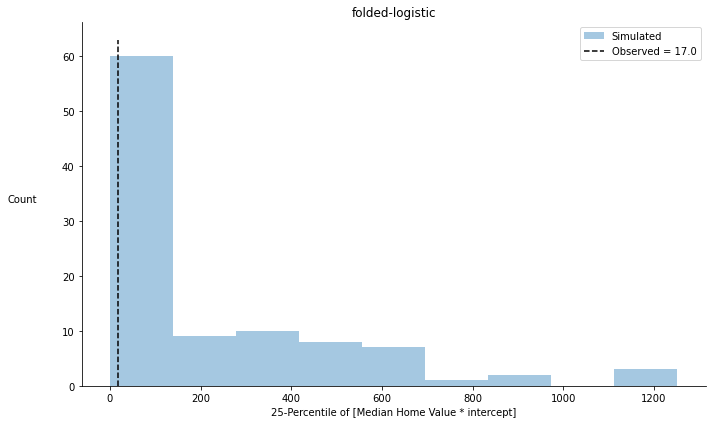

In [10]:
def percentile_closure(percentile):
    def _calc_25th_percentile(array_like):
        return np.percentile(array_like, percentile, axis=0)
    return _calc_25th_percentile


def make_percentile_plot(
    calc_percentile_func, design, obs_outcomes, sim_outcomes, col_names, save
):
    column_idx = col_names.index(COLUMN)
    sim_product = sim_outcomes * design[:, column_idx][:, None]
    obs_product = obs_outcomes * design[:, column_idx]
    percentiles_of_sim_product = calc_percentile_func(sim_product)
    percentiles_of_obs_product = calc_percentile_func(obs_product)

    p_value = (percentiles_of_sim_product > percentiles_of_obs_product).mean()

    sim_label = "Simulated"
    obs_label = "Observed = {:.1f}\nP-value = {:.0%}".format(
        percentiles_of_obs_product, p_value
    )

    plot = sbn.distplot(
        percentiles_of_sim_product, kde=False, hist=True, label=sim_label
    )
    ymin, ymax = plot.get_ylim()
    plot.vlines(
        percentiles_of_obs_product,
        ymin,
        ymax,
        label=obs_label,
        linestyle="dashed",
        color="black",
    )
    plot.legend(loc="best")

    xlabel = (
        "{}-Percentile of [Median Home Value * {}]".format(PERCENTILE, COLUMN)
    )
    plot.set_xlabel(xlabel)
    plot.set_ylabel("Count", rotation=0, labelpad=40)
    plot.set_title(MODEL)

    plot.figure.set_size_inches(10, 6)
    sbn.despine()
    plot.figure.tight_layout()
    if save:
        plot.figure.savefig(PLOT_PATH, dpi=500, bbox_inches="tight")
    return plot

calc_percentile = percentile_closure(PERCENTILE)

percentile_plot = make_percentile_plot(
    calc_percentile,
    training_design_np,
    training_outcomes_np,
    prior_sim_outcomes,
    training_design_column_names,
    SAVE,
)

# To-Do:
Add complete compendium of desired prior predictive plots.

In [11]:
# Make desired prior predictive plots